# <a id='top'>Covid-19 Data Analysis</a>

The purpose of this project is to clean, explore, and draw insights from the Johns Hopkins COVID-19 dataset ([source](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker)) and the State and Policy Orders dataset ([source](https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders)). 

### Table of Contents

* 1 [data cleaning](#cleaning)<br>
    * 1.1 [Johns Hopkins](#jh)<br>
    * 1.2 [State and Policy Orders](#sp)<br> 
* 2 [data visualization](#viz)<br>
    * 2.1 [New Cases and Deaths](#2.1)<br>
    * 2.2 [Policy Data Overlay](#2.2)<br>
* 3 [correlation between cases and policies](#corr)<br>
    * 3.1 [Finding Correlations](#3.1)<br>
    * 3.2 [Evaluating Correlations](#3.2)<br>
    * 3.3 [Discussion](#3.3)<br>
    * 3.4 [Linear Regression](#3.4)<br>
* 4 [Conclusion](#4)<br>

### important notes: 
- When investigating the new case and death numbers by location, we will control for county / state population by reporting these figures per 100,000 people. I will be referring to these as the *normalized* values. 

### Associated links: 
- extended discussion of [data cleaning](https://nbviewer.jupyter.org/github/apalermo01/covid-19-data-analysis/blob/main/Covid-19%20data%20cleaning.ipynb)

- [github repo](https://github.com/apalermo01/covid-19-data-analysis)

# TODO: 
 
- [x] aggregate similar policies to reduce number of features
- [ ] automate and further vectorize data preprocessing to speed things up 
- [x] implement separate test notebook to work with while main notebook is running
- [ ] visualize standard deviations in policy correlations with other key metrics
- [ ] automate 'binning' of time periods to rapidly experiment with different date ranges to optimize model 

# 0 Imports and configurations

In [1]:
# from IPython.display import display
# from IPython.display import HTML
# import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# # This line will hide code by default when the notebook is exported as HTML
# di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# # This line will add a button to toggle visibility of code blocks, for use with the HTML export version
# di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

In [2]:
# configuration settings
%reset -f
%config InlineBackend.figure_format = 'svg'

# basics 
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time

# visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from ipywidgets import interact, Dropdown, SelectMultiple, fixed

# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# miscellaneous
import re
from tabulate import tabulate
from IPython.display import clear_output
import us
import requests

# 1 <a id='cleaning'>Data Cleaning</a>
[back to top](#top)

First, load each of the datasets. df = Johns Hopkins COVID-19 dataset, df2 = policy dataset. df is queried directly from dataworld, while the policy dataset is pulled from a local file.

**Load case and death data**

In [3]:
df = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')

**Use HTML source to get policy data** 
I haven't been able to find a conventient way to automate data retrieval, so use the HTML source to get the filename (which changes with every update) to download the most current version of the policy data

In [4]:
html = requests.get("https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders").text
policy_file = html.split("a href=\"/dataset/covid-19-state-and-county-policy-orders")[1]\
    .split("<span>plotly</span>")[0]\
    .split("https://plot.ly/external/?url=")[1]\
    .split("\">")[0]
df2 = pd.read_csv(policy_file)

In [5]:
print("Johns Hopkins datset (raw): ")
df.head()

Johns Hopkins datset (raw): 


,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000,new_cases,new_deaths,new_cases_per_100_000,new_deaths_per_100_000,new_cases_7_day_rolling_avg,new_deaths_7_day_rolling_avg
0,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-22,18181.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-23,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-24,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-25,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-26,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [6]:
print("State and Policy orders dataset (raw): ")
df2.head()

State and Policy orders dataset (raw): 


,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,MS,Hinds,28049.0,county,2020-07-13,Entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,NaN
1,AZ,NaN,NaN,state,2020-05-16,Houses of Worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...,NaN
2,OR,NaN,NaN,state,2020-05-15,Non-Essential Businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...,NaN
3,ND,Pembina,38067.0,county,2020-09-03,Phase 5,start,Policy_Details: - Most normal activity can res...,sip_submission_form: https://ndresponse.gov/si...,5.0
4,OR,Lane,41039.0,county,2020-05-15,New Phase,start,Policy_Details: Gatherings up to 25 people all...,sip_submission_form: https://www.eugene-or.gov...,NaN


## <a id='jh'>1.1 Johns Hopkins Covid-19 dataset</a>
[back to top](#top)

Shorten column names then look for nulls, unexpected data types, and invalid records. A more detailed look at the data cleaning process is found in the data cleaning notebook.  

In [7]:
df.rename(columns={
    'cumulative_cases_per_100_000'  : 'cumulative_cases_1e6', 
    'cumulative_deaths_per_100_000' : 'cumulative_deaths_1e6',
    'new_cases_per_100_000'         : 'new_cases_1e6', 
    'new_deaths_per_100_000'        : 'new_deaths_1e6', 
    'new_cases_7_day_rolling_avg'   : 'new_cases_7day', 
    'new_deaths_7_day_rolling_avg'  : 'new_deaths_7day'
    }, inplace=True)

Summary of expected datatypes and values: 

| column | details | accepted values |
|-----|------|--------|
| uid | Unique location identifier | numpy.int64
| location_type | type of location data | string
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| location_name | location name | string
| state | state name | string
| date | date of record | datetime object
| total_population | county population | positive integer
| cumulative_cases | total number of covid cases | positive integer
| cumulative_cases_1e6 | normalized total covid cases | positive float
| cumulative_deaths | total number of covid deaths | positive integer
| cumulative_deaths_1e6 | normalized total covid deaths | positive float
| new_cases | number of new covid cases | positive integer
| new_deaths | number of new covid deaths | positive integer
| new_cases_1e6 | normalized number of new cases | positive float
| new_deaths_1e6 | normalized number of new deaths | positive float
| new_cases_7day | 7 day average of new cases | positive float
| new_deaths_7day | 7 day average of new deaths | positive float

Check the distribution of numerical fields, number of nulls in each column, and the datatypes present in each column. 

Define a custom function to evaluate nulls and data types. This is primarily for convenience, as df.info() gives similar information but we're interested in the number of nulls and unique datatypes for each series (since by default df.info() writes 'object' when a series has heterogenous datatypes). 

In [8]:
def eval_df(df):
    """Count the number of nulls and list datatypes present in each column in the input DataFrame."""
    
    table = []
    for col in df.columns: 
        table.append([col, df[col].isnull().sum(), set([type(i) for i in df[col].values])])
        
    print(tabulate(table, headers=["field", "num_nulls", "datatypes"]))

In [9]:
df.describe()

,uid,fips_code,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day
count,1.247664e+06,1.243924e+06,1.204280e+06,1.247664e+06,1.204280e+06,1.247664e+06,1.204280e+06,1.244328e+06,1.244328e+06,1.201060e+06,1.201060e+06,1.227102e+06,1.230232e+06
mean,8.352961e+07,3.310136e+04,1.013323e+05,1.925499e+03,1.868410e+03,4.655738e+01,3.657874e+01,2.083268e+01,3.509075e-01,2.152041e+01,3.914967e-01,2.095918e+01,3.642709e-01
std,3.206731e+06,1.861217e+04,3.260459e+05,1.093918e+04,2.746346e+03,2.807532e+02,6.285857e+01,1.438034e+02,5.376671e+00,5.560312e+01,2.623695e+00,1.311635e+02,2.575935e+00
min,6.307200e+07,1.001000e+03,7.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.590000e+03,-3.962000e+03,-5.975850e+03,-1.685400e+02,0.000000e+00,0.000000e+00
25%,8.401811e+07,1.908500e+04,1.121425e+04,2.000000e+00,2.349000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.402921e+07,3.101800e+04,2.595050e+04,1.130000e+02,5.144000e+02,2.000000e+00,6.570000e+00,1.000000e+00,0.000000e+00,3.100000e+00,0.000000e+00,1.710000e+00,0.000000e+00
75%,8.404612e+07,4.713300e+04,6.655225e+04,8.440000e+02,2.710650e+03,1.700000e+01,4.818000e+01,9.000000e+00,0.000000e+00,2.428000e+01,0.000000e+00,1.014000e+01,1.400000e-01
max,8.410000e+07,9.999900e+04,1.009805e+07,1.104720e+06,3.202487e+04,1.635300e+04,8.400200e+02,2.942300e+04,1.553000e+03,9.370100e+03,2.793300e+02,1.607743e+04,2.445700e+02


In [10]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  --------------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                     3740  {<class 'numpy.float64'>}
location_name                  748  {<class 'str'>, <class 'float'>}
state                            0  {<class 'str'>}
date                             0  {<class 'str'>}
total_population             43384  {<class 'numpy.float64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6         43384  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6        43384  {<class 'numpy.float64'>}
new_cases                     3336  {<class 'numpy.float64'>}
new_deaths                    3336  {<class 'numpy.float64'>}
new_cases_1e6                46604  {<class 'numpy.float64'>}
new_deaths_1e6               46604  {<class 'n

While inspecting these tables a few issues become apparent: 

1) null values in most columns

2) some fields that should be integers are floats (total_population, new_cases, new_deaths)

3) some values for location_name are floats

4) negative values in new_cases, new_deaths, and their normalized equivalents 

We can likely eliminate some of these issues by throwing out some locations that are not a 'county' and locations not in the 50 states. 

In [11]:
df['location_type'].unique()

array(['county', 'special_exception', 'out_of_state',
       'count_unassigned_to_location'], dtype=object)

In [12]:
df = df.drop(df[df['location_type']!='county'].index) # drop location_types that are not counties

states = [elem.name for elem in us.states.STATES]     # get list of u.s. states
df = df.drop(df[~df['state'].isin(states)].index)     # drop anything not in one of the 50 states (also drops DC)

In [13]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  -------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                        0  {<class 'numpy.float64'>}
location_name                    0  {<class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'str'>}
total_population                 0  {<class 'numpy.float64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6             0  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6            0  {<class 'numpy.float64'>}
new_cases                     3141  {<class 'numpy.float64'>}
new_deaths                    3141  {<class 'numpy.float64'>}
new_cases_1e6                 3141  {<class 'numpy.float64'>}
new_deaths_1e6                3141  {<class 'numpy.float64'>}
new_case

Restricting locations had the effect of throwing out nulls in fips_code, location_name, total_poplulation, cumulative_cases_1e6, and cumulative_deaths_1e6. 

Let's make the locations more consistent by converting 'location_name' to 'county' (this will ensure consistency with the policy dataset). Aditionally, we will make a new column with the combined county and state name. 

In [14]:
df['full_loc_name'] = df['location_name'] + ', ' + df['state']
df['location_name'] = df['location_name'].str.lower()

# re-order columns
cols = df.columns.tolist()
cols = cols[:6] + [cols[-1]] + cols[6:-1]
df = df[cols]

df.rename(columns={'location_name' : 'county'}, inplace=True)

Next, convert 'date' to datetime. 

In [15]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

We will now handle the negative and null values is the numerical columns. 

The nulls in new_cases(\_1e6) and new_deaths(\_1e6) all occur on 2020-01-22, the first day on which reporting occurs, so we can set these to zero.  

The negative values in these columns can also be set to zero. On the [disucssion page](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker/discuss/johns-hopkins-coronavirus-case-tracker/zimsf5ki) for this dataset in dataworld  user nickyforester adressed the negative values in new_cases and new_deaths with the following comment: 

>We calculate the new_cases and new_deaths columns as the difference in the cumulative count from the previous day. Discrepancies do sometimes appear in the Johns Hopkins data where cumulative counts decrease from one day to the next. This can happen if state or local governments adjust their historical data.
Johns Hopkins works to fix these inconsistencies in their data. When they do, the timeseries won't show a decreasing cumulative count. Decreases in the cumulative count — or negative new case/death counts — should be treated as errors/inconsistencies, not as a correction from Johns Hopkins.

For those interested, I started an in-depth analysis on how these negative values are distributed in the data_cleaning notebook. 

Additionally, we will cast all these columns to integers. 

In [16]:
df.head()

,uid,location_type,fips_code,county,state,date,full_loc_name,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day
29920,84001001,county,1001.0,autauga,Alabama,2020-01-22,"Autauga, Alabama",55200.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
29921,84001001,county,1001.0,autauga,Alabama,2020-01-23,"Autauga, Alabama",55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
29922,84001001,county,1001.0,autauga,Alabama,2020-01-24,"Autauga, Alabama",55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
29923,84001001,county,1001.0,autauga,Alabama,2020-01-25,"Autauga, Alabama",55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
29924,84001001,county,1001.0,autauga,Alabama,2020-01-26,"Autauga, Alabama",55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [17]:
cols = ['new_cases', 'new_deaths', 'new_cases_1e6', 'new_deaths_1e6']

for col in cols: 
    df[col].fillna(value=0, inplace=True)
    df[col].clip(lower=0, inplace=True)

cols2 = ["fips_code", "total_population", "new_cases", "new_deaths"]
df[cols2] = df[cols2].astype(np.int64)

In the 7 day running averages, most of the nulls occur in the first few days, so we will set those to zero. 

There are additional nulls distributed throughout the dataset. We will loop through these nulls and re-calculate the 7-day running average. If you're running this at home, this step should take ~6-7 minutes.

In [18]:
# Start timer. 
start = time.time()

# Set rolling averages to zero in the first few days of measurements.
df[['new_cases_7day', 'new_deaths_7day']] = df[['new_cases_7day', 'new_deaths_7day']].mask(
    (df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')), df[['new_cases_7day', 'new_deaths_7day']].fillna(0)
    )

# Get dataframes where normalized new_cases and new_deaths are null
nulls_case7day = df[df['new_cases_7day' ].isnull()]
nulls_death7day = df[df['new_deaths_7day'].isnull()]

# Pre-define timedelta for efficiency. 
days_7 = timedelta(days=7)

# Prepare some outputs since this function will take a while. 
i = 0
num_elem = len(nulls_case7day)
msg = "Looping through nulls in new_cases_7day. Please be patient, this may take a while"
print(msg)

# Loop through nulls in new_cases_7day
for index, data in nulls_case7day.iterrows():
    
    # Output for inpatient people like me. 
    i += 1
    if i%10 == 0: 
        print(f"index: {i}/{num_elem}")
        
    if i%250 == 0: 
        clear_output()
        print(msg)
        print(f"index: {i}/{num_elem}")
    
    # Calculate rolling average at the datapoint of interest
    df.loc[index, ['new_cases_7day']] = np.sum((
        [df['new_cases'][(df['full_loc_name'] == data.full_loc_name) & 
        ((df['date'] <= data.date) & (df['date'] > data.date-days_7))].values])) / 7
    
# Reset output. 
clear_output()
print("Looping through nulls in new_deaths_7day. Please be patient, this may take a while")
i = 0
num_elem = len(nulls_death7day)

# Loop through nulls in new_deaths_7day
for index, data in nulls_death7day.iterrows():
    
    # Output status. 
    i += 1
    if i%10 == 0: 
        print(f"index: {i}/{num_elem}")
    
    # Calculate rolling average at datapoint of interest. 
    df.loc[index, ['new_deaths_7day']] = np.sum(([df['new_deaths'][
        (df['full_loc_name'] == data.full_loc_name) & 
        ((df['date'] <= data.date) & (df['date'] > data.date-days_7))].values])) / 7

# Output complete. 
clear_output()
print("done :)")
end = time.time()
print(f"time elapsed: {end-start}")

done :)
time elapsed: 96.2311487197876


Finally, make a few new columns with full location name (county, state) and normalized 7 day rolling averages. Convert location name to lowercase as well. 

In [19]:
df["new_cases_7day_1e6" ] = df['new_cases_7day' ] / (df['total_population'] / 1e5)
df["new_deaths_7day_1e6"] = df['new_deaths_7day'] / (df['total_population'] / 1e5)

Re-check the data to see if there are any missed issues

In [20]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  ----------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                        0  {<class 'numpy.int64'>}
county                           0  {<class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'numpy.datetime64'>}
full_loc_name                    0  {<class 'str'>}
total_population                 0  {<class 'numpy.int64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6             0  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6            0  {<class 'numpy.float64'>}
new_cases                        0  {<class 'numpy.int64'>}
new_deaths                       0  {<class 'numpy.int64'>}
new_cases_1e6                    0  {<class 'numpy.float64'>}
new_deaths

## 1.2 <a id='sp'>State and Policy Orders</a>
[back to top](#top)

Summary of expected datatypes and values: 

| column | details | accepted values |
|-----|------|--------|
| state_id | state name | string
| county | county name (this should be the same as county in the Johns Hopkins dataset) | string, county name for county level policies "statewide" for state policies
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| policy_level | scope of policy | string, 'county' or 'state
| date | date of policy implementation | datetime object
| policy_type | brief description of policy classification | datetime object
| start_stop | whether this is the start of a restriction or lifting of a restriction | 'start' or 'stop' (string)
| comments | additional information | string
| source | source for policy info | string
| total_phases | total number of phases | positive integer

Since this is mostly text-based data, skip .describe()

In [21]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  --------------------------------
state_id                0  {<class 'str'>}
county               1676  {<class 'str'>, <class 'float'>}
fips_code            1676  {<class 'numpy.float64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'str'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}
total_phases         2937  {<class 'numpy.float64'>}


Data cleaning for the policy dataset is somewhat more straightforward. To start: 

1) drop policies not implemented in the 50 states

2) convert state abbreviations to the full name 

3) re-name 'state_id' to 'state'

4) drop total_phases since we won't be using it 

5) nulls in 'county' are statewide policies, so fill nulls with 'statewide'

6) convert 'county' to lowercase

7) convert 'date' from int to datetime

In [22]:
df2.head()

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,MS,Hinds,28049.0,county,2020-07-13,Entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,NaN
1,AZ,NaN,NaN,state,2020-05-16,Houses of Worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...,NaN
2,OR,NaN,NaN,state,2020-05-15,Non-Essential Businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...,NaN
3,ND,Pembina,38067.0,county,2020-09-03,Phase 5,start,Policy_Details: - Most normal activity can res...,sip_submission_form: https://ndresponse.gov/si...,5.0
4,OR,Lane,41039.0,county,2020-05-15,New Phase,start,Policy_Details: Gatherings up to 25 people all...,sip_submission_form: https://www.eugene-or.gov...,NaN


In [23]:
abbr = [elem.abbr for elem in us.states.STATES]

df2 = df2.drop(df2[~df2['state_id'].isin(abbr)].index)                     
df2.replace(to_replace=us.states.mapping('abbr', 'name'), inplace=True)    
df2.rename(columns={'state_id' : 'state'}, inplace=True)                   
df2.drop('total_phases', axis=1, inplace=True)                             
df2['county'].fillna(value='statewide', inplace=True)                      
df2['county'] = df2['county'].str.lower()                                  
df2.loc[:, 'date'] = '2020' + df2['date'].str[4:] # some formatting issues in 'date': 0020 instead of 2020
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')          

There are several mismatches between 'county' in df2 and 'location_name' in df. All of these end with a modifier- most of them end in 'county' (e.g. 'bronx county') and a few end in 'municipality' and 'borough'. We'll simply strip these off in df2. 

In [24]:
county_match  = re.compile(" county$")
munici_match  = re.compile(" municipality$")
Borough_match = re.compile(" borough$")

df2['county'].replace(to_replace=county_match,  value='', inplace=True)
df2['county'].replace(to_replace=munici_match,  value='', inplace=True)
df2['county'].replace(to_replace=Borough_match, value='', inplace=True)

Nulls in fips_code relate to statewide polices, so replace the nulls with the 2 digit fips code for the state 

In [25]:
for index, data in df2.iterrows(): 
    if data.policy_level == 'state': 
        df2.loc[index, 'fips_code'] = np.int64(us.states.lookup(data.state).fips)

Convert fips_code to integers

In [26]:
df2['fips_code'] = df2['fips_code'].astype(np.int64)

Examine all the policy types in this dataset.

In [27]:
print(np.sort((df2['policy_type'].unique())))

['Agriculture' 'Allow Audio Only Telehealth'
 'Allow Expand Medicaid Telehealth Coverage'
 'Alternative Care Facilities ' 'Bars' 'Childcare (K-12)'
 'Colleges & Universities' 'Construction' 'Day Care'
 'Day camps/overnight camps' 'Education' 'Election' 'Entertainment'
 'Executive Order' 'Food and Drink' 'Froze Mortgage Payments' 'Gatherings'
 'Graduation' 'Graduation Ceremony guidelines' 'Gyms' 'Health Risk Status'
 'Houses of Worship'
 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
 'Mandate Face Mask Use By All Individuals In Public Spaces'
 'Manufacturing' 'Mask Requirement' 'Medical'
 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'
 'New Phase' 'Non-Essential Businesses' 'Nursing Home Visitations'
 'Nursing Homes' 'Order Freezing Utility Shut Offs'
 'Outdoor and Recreation' 'Personal Care' 'Phase 1' 'Phase 2' 'Phase 2, 3'
 'Phase 3' 'Phase 3 Step 2' 'Phase 4' 'Phase 5' 'Public Gatherings'
 'Public Health Advisory System' 'Quarantine'
 '

drop vague / unrelated policies

In [28]:
policies_drop = ['New Phase', 'Phase 1', 'Phase 2', 'Phase 2, 3', 'Phase 3', 'Phase 3 Step 2', 'Phase 4', 'Phase 5']
print(f"dropping policies: {policies_drop}")
df2 = df2.drop(df2[df2['policy_type'].isin(policies_drop)].index)

dropping policies: ['New Phase', 'Phase 1', 'Phase 2', 'Phase 2, 3', 'Phase 3', 'Phase 3 Step 2', 'Phase 4', 'Phase 5']


In [29]:
print(np.sort((df2['policy_type'].unique())))

['Agriculture' 'Allow Audio Only Telehealth'
 'Allow Expand Medicaid Telehealth Coverage'
 'Alternative Care Facilities ' 'Bars' 'Childcare (K-12)'
 'Colleges & Universities' 'Construction' 'Day Care'
 'Day camps/overnight camps' 'Education' 'Election' 'Entertainment'
 'Executive Order' 'Food and Drink' 'Froze Mortgage Payments' 'Gatherings'
 'Graduation' 'Graduation Ceremony guidelines' 'Gyms' 'Health Risk Status'
 'Houses of Worship'
 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
 'Mandate Face Mask Use By All Individuals In Public Spaces'
 'Manufacturing' 'Mask Requirement' 'Medical'
 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'
 'Non-Essential Businesses' 'Nursing Home Visitations' 'Nursing Homes'
 'Order Freezing Utility Shut Offs' 'Outdoor and Recreation'
 'Personal Care' 'Public Gatherings' 'Public Health Advisory System'
 'Quarantine' 'Renter Grace Period Or Use Of Security Deposit To Pay Rent'
 'Reopened ACA Enrollment Using a 

Some of these names are a bit too long. Rename any policy type longer than 40 characters, then convert all of them to lowercase

In [30]:
policy_replacements_dict = {
    'Stop Initiation Of Evictions Overall Or Due To Covid Related Issues'  : 'Stop Initiation Of Evictions',
    'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'  : 'Modify Medicaid Requirements', 
    'Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues' : 'Stop Enforcement Of Evictions', 
    'Mandate Face Mask Use By All Individuals In Public Facing Businesses' : 'Mandate Face Masks In Businesses', 
    'Mandate Face Mask Use By All Individuals In Public Spaces'            : 'Mandate Face Masks In Public Spaces', 
    'Reopened ACA Enrollment Using a Special Enrollment Period'            : 'ACA Special Enrollment Period', 
    'Suspended Elective Medical Dental Procedures'                         : 'Suspend Elective Dental Procedures', 
    'Allow Expand Medicaid Telehealth Coverage'                            : 'Expand Medicaid Telehealth Coverage', 
    'Renter Grace Period Or Use Of Security Deposit To Pay Rent'           : 'Grace Period / Security Deposit for Rent'
}

for key in policy_replacements_dict.keys():
    df2['policy_type'].replace(to_replace=key, value=policy_replacements_dict[key], inplace=True)
    
df2['policy_type'] = df2['policy_type'].str.lower()

Drop policies that were enacted before the first date in the case dataset and policies scheduled in the future

In [31]:
df2 = df2.drop(df2[(df2['date'] < min(df['date'])) | (df2['date'] > datetime.today())].index)

Final check: 

In [32]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  ----------------------------
state                   0  {<class 'str'>}
county                  0  {<class 'str'>}
fips_code               0  {<class 'numpy.int64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'numpy.datetime64'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}


Finally, export these datasets to csv files to build the associated dashboard in tableau

In [33]:
df.to_csv("case_data_clean.csv")
df2.to_csv("policy_data_clean.csv")

# 2 <a id='viz'>Data visualizations</a>
[back to top](#top)

# 2.1 <a id='2.1'>New cases and deaths</a>
[back to top](#top)

Here, we'll write a few functions that plot data at the county, state, and national levels. 

In [34]:
def get_cases(level="county", county="orange", state="California", df=df):
    
    """ Return the new_case and new_death numbers at the given level of aggregation (county, state, or national). 
    
    Parameters
    ----------
    level : {'county', 'state', 'national'}
        If county, returns a DataFrame filtered to a specific county (default). 
        If state, aggregates the DataFrame to the state level. 
        If national, or any other input, returns the DataFrame aggregated to the national level. 
    county : string 
        desired county
    state : string 
        desired state
    df : pandas DataFrame 
        DataFrame to use, df by default
    
    Returns 
    ----------
    DataFrame
        case_data filtered to a specific county or aggregated to the state / national level with index=date
    """
    # return county level data
    if level == "county":
        return_df = df[(df["county"] == county) & (df["state"] == state)].set_index("date")[['new_cases_1e6', 
                                                                                             'new_deaths_1e6', 
                                                                                             'new_cases_7day_1e6', 
                                                                                             'new_deaths_7day_1e6',
                                                                                            ]]
        
        return return_df
    
    # If this is filtered at the state level, filter df to desired state. Otherwise, return national-level data.
    if level == "state": 
        df = df[df['state'] == state]

    # Reindex on location name.
    df = df.set_index(["full_loc_name"])
    
    # Get a list of all dates.
    all_dates = df['date'].unique()

    # Get the total population from the county populations.
    total_population =  sum([(pops / 1e5) for pops in df[df['date'] == all_dates[0]]['total_population']]) 
    
    # Add up the case and death #s that have the same date.
    new_cases       = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_cases_1e6']]) 
                              for dates in all_dates]

    new_deaths      = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_deaths_1e6']]) 
                              for dates in all_dates]

    new_cases_7day  = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_cases_7day_1e6']]) 
                              for dates in all_dates]

    new_deaths_7day = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_deaths_7day_1e6']]) 
                              for dates in all_dates]


    return_df = pd.DataFrame(data={'date'               : all_dates,
                                   'new_cases_1e6'      : new_cases, 
                                   'new_deaths_1e6'     : new_deaths,
                                   'new_cases_7day_1e6' : new_cases_7day,
                                   'new_deaths_7day_1e6': new_deaths_7day
                                   }).set_index(["date"]) 
    return return_df

In [35]:
def plot_cases(level="county", county="orange", state="California", df=df, fade=0.75, style="whitegrid", ax=None, fig=None):
    
    """ A function which plots the COVID-19 case/death data and 7 day average.
    
    Parameters
    ---------- 
    level : {'county', 'state', 'national'}
        Value to pass to get_cases()
    county : string 
        desired county
    state : string 
        desired state
    df : pandas DataFrame 
        DataFrame to use, df by default
    style : string
        Seaborn plot style (default: "whitegrid")
    fade : float
        level of transparency for new_cases_1e6 and new_deaths_1e6 (default: 0.75)
        
    Returns 
    ----------
    matplotlib.figure.Figure
    ndarray containing the two axis handles
    pandas DataFrame
    """
    
    # Get the data. 
    cases = get_cases(level, county, state, df)
        
    # Set up plots. 
    if ax is None: 
        fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True);
    plt.subplots_adjust(hspace=0.02)
    sns.set_style(style)
    
    # Plot cases.
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_cases_1e6","new_cases_7day_1e6"],
        label=["Cases per capita", "7-day average"],
        ax=ax[0]
        );

    # Plot deaths. 
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_deaths_1e6","new_deaths_7day_1e6"],
        label=["Deaths per capita", "7-day average"],
        ax=ax[1]
        );
    
    # Format axis labels. 
    ax[0].set_ylabel("cases per 100,000")
    ax[1].set_ylabel("deaths per 100,000")
    
    # Set plot title based on level of aggregeation (county, state, or national)
    if level == "county":
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {county} County, {state}");
    elif level == "state": 
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {state}");
    else: 
        ax[0].set_title("New COVID-19 cases and deaths per 100,000 in the United States")
    
    
    return fig, ax, cases

Plot the cases at a few different levels

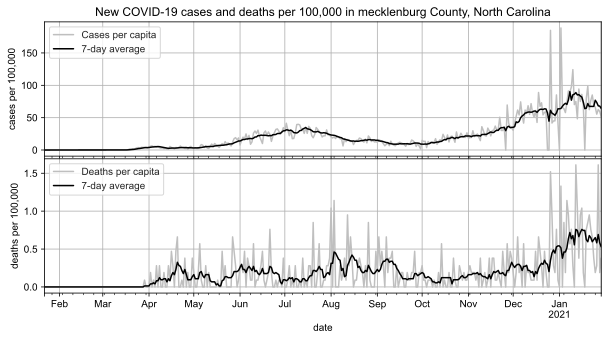

In [36]:
plot_cases(level="county", county="mecklenburg", state="North Carolina");

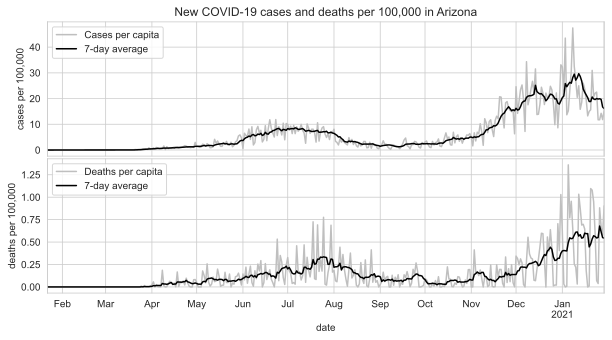

In [37]:
plot_cases(level="state", state="Arizona");

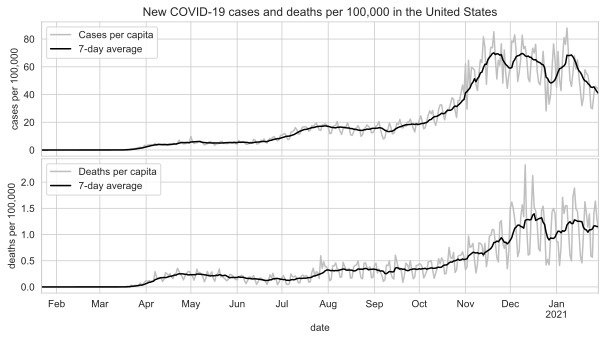

In [38]:
plot_cases(level="national");

# 2.2 <a id='2.2'>Policy data overlay</a>
[back to top](#top)<br>
First, we'll get the policy data for a specific county at the state level, county level, or both. Then, make a plot that overlays policy enactments and case / death numbers with a few selected policies. 

In [39]:
def get_policy_data(state="California", county="statewide", state_policies=True, county_policies=True, df=df2):
   
    """Get the policy data at county level, state level, or both.  

    Parameters
    ----------
    state : string 
        selected state
    county : string
        selected county
    state_policies : boolean 
        include policies at the state level (default: True)
    county_policies : boolean 
        include policies at the county level (default: True)
    
    Returns
    ---------- 
    filtered DataFrame
    """
    # state AND county policies
    if state_policies and county_policies:

        return df[(df['state'] == state) &
                  ((df["county"] == county) | (df["county"] == "statewide"))]
    
    # state policies only
    elif state_policies and not county_policies: 
        return df[ (df['state'] == state) & (df["county"] == "statewide")]
    
    # county policies only
    else:  
         return df[ (df['state'] == state) & (df["county"] == county)]

## TODO: revise line stacks for multiple policies on the same day

In [40]:
def plot_cases_and_policies(
        county, state, 
        colors=sns.color_palette()[:],
        #colors=['k', 'b', 'r', 'g'],  
        policies=[
            "mask requirement", 
            "mandate face masks in public spaces", 
            "mandate face masks in businesses", 
            "shelter in place", 
            "state of emergency"],
                           
        labels=["mask requirement", "face mask mandate (public spaces)", 
            "face mask mandate (businesses)", 
            "shelter in place", 
            "state of emergency"],
    ):

    
    """Plot the cases overlayed with the policies. 
    
    Parameters
    ---------- 
    county : string 
        county of interest
    state : string
        state of interest
    policies : array-like
        policies to plot (default: face mask mandates in public spaces and businesses, shelter in place, 
        and state of emergency)
    colors : array-like
        line colors for respective policies (in order) (default: k, b, r, g)
    labels : array-like 
        legend labels for the selected policies (default: "face mask mandate (public spaces)", 
        "face mask mandate (businesses)", "shelter in place", and "state of emergency")
    style : string 
        sns plot style (whitegrid by default, dark styles not recommended)
    fade : float
        level of transparency for new_cases_1e6 and new_deaths_1e6 (default: 0.75)
    
    The marks for policies are aligned with the 7 day average, using colors to indicate policy types, endcaps for 
    state (diamond) or county (circle), and linestyle to distinguish the start (solid line) or stop (dotted line) of a 
    policy. 
    
    Returns
    ----------
    ndarray containing the two axis handles used for plotting
    """

    
    # Plot case / death data.
    plt.figure();
    fig, ax, df = plot_cases(level="county", county=county, state=state);

    # Get the policy data for the selected state and county.
    policy_data = get_policy_data(state, county);

    # Set a solid line to be the start of a policy and a dashed line to be the end.
    styles_start_stop = {
        "start" : '-', 
        "stop" : ':'
    }

    # Set color codes for selected policies.
    styles_policy_type = {policies[i] : colors[i] for i in range(len(policies))}
    
    # Set labels for legend.
    legend_policy_labels = {policies[i] : labels[i] for i in range(len(policies))}
    
    # Define plot parameters. 
    legend_position = (1, 1) 
    line_split = 0                
    mark_length = 0.2
    plot_policies = policy_data[policy_data['policy_type'].isin(policies)]
    labels = []
    
    # Loop through both axes. 
    for i in range(2):
        
        # Expand y axis to get some extra room on the bottom.
        ax[i].set_ylim(-max(ax[i].lines[0].get_ydata())*(0.15))
        
        # Loop through policies.
        for index, row in plot_policies.sort_values(by="date").iterrows():

            # Get the y-positional coordinate for the line on the selected day (between 0 and 1). 
            if i == 0: 
                center = df[df.index == row.date]['new_cases_7day_1e6'].values[0]
            else: 
                center = df[df.index == row.date]['new_deaths_7day_1e6'].values[0]
            
            # Calculate where to position the line horizontally.  
            days_serial = (row.date - pd.Timestamp(year=1970, month=1, day=1)).days
            cent_coord = ax[i].transLimits.transform((days_serial, center))[1]

            # loop through all the policies enacted on a given day. Normally, this is 1, but we want to visualize all the
            # policies enacted on the same day, so we're goint to split the line accordingly.

            num_policies = plot_policies['date'].value_counts()[row.date]
            
            # Split the mark if there are multiple policies enacted on the same day.
            if num_policies > 1: 
                hmin = (cent_coord - (mark_length/2)) + line_split * (mark_length/num_policies)
                hmax = (cent_coord + (mark_length/2)) - \
                    (mark_length/num_policies) + ((line_split*mark_length) / num_policies)
                line_split += 1

            if num_policies == 1:
                hmin = (cent_coord - (mark_length/2))
                hmax = (cent_coord + (mark_length/2))
                line_split=0
                
            # Plot the mark.
            line = ax[i].axvline(x         = row.date,
                                 linestyle = styles_start_stop[row.start_stop], 
                                 color     = styles_policy_type[row.policy_type], 
                                 lw        = 2,
                                 ymin      = hmin, 
                                 ymax      = hmax,
                                )

            # Add the policy to the legend if it's not already in the list of labels
            if (row.policy_type not in labels): 
                labels.append(row.policy_type);
                
            # Set markers for state or county policies. 
            if row.policy_level == "state":
                line.set_marker('d')
                
            else: 
                line.set_marker('o')
                
            ax[i].legend(loc="upper left")
        
    # Make the legend. 
    legend_lines = []
    
    # Use square boxes to denote colors for policy types. 
    [legend_lines.append(Line2D([0], [0], marker="s", markersize=15, color='w', 
                           markerfacecolor=styles_policy_type[policy], lw=3, label=policy)) for policy in labels]
    
    # Draw a diamond to indicate a state policy. 
    legend_lines.append(Line2D([0], [0], marker="d", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label="state policy"))
    
    # Draw a circle to indicate a county policy. 
    legend_lines.append(Line2D([0], [0], marker="o", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label="county policy"))
    
    # Use a solid line for policy start, dotted line for policy stop. 
    legend_lines.append(Line2D([0], [0], linestyle='-', color='k', lw=3, label = "policy start"))
    legend_lines.append(Line2D([0], [0], linestyle=':', color='k', lw=3, label = "policy stop"))
                   
     
    # Finally, draw the legend. 
    leg1 = ax[0].legend(loc='upper left')
    leg2 = ax[0].legend(handles=legend_lines, bbox_to_anchor=legend_position)
    ax[0].add_artist(leg1);
            
    return ax

<Figure size 432x288 with 0 Axes>

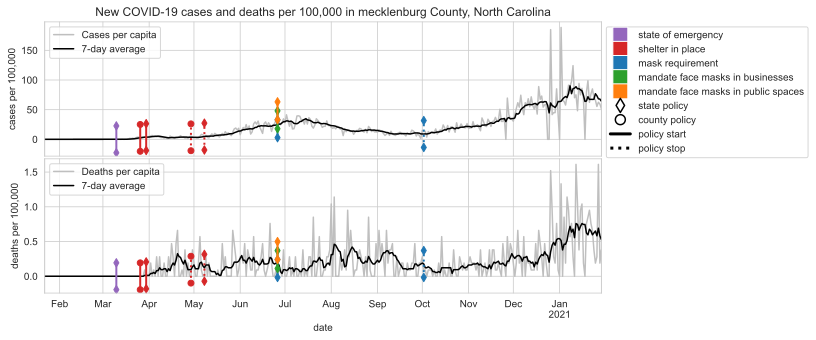

In [41]:
plot_cases_and_policies(county="mecklenburg", state="North Carolina");

<Figure size 432x288 with 0 Axes>

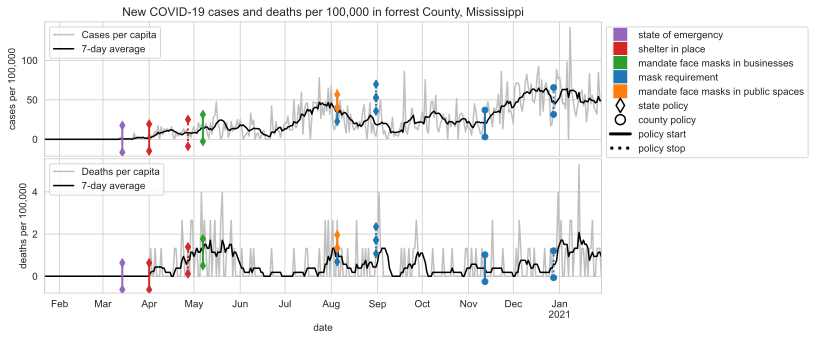

In [42]:
plot_cases_and_policies("forrest", "Mississippi", colors=sns.color_palette()[:]);

# 3. <a id='corr'>Connecting case numbers and covid policies</a>
[back to top](#top)<br>

# 3.1 <a id='3.1'>Finding Correlations</a>
[back to top](#top)<br>

Find the correlation between case / death numbers and policies.

First, calculate the change in the number of new cases at the point of a policy implementation and 14 days afterward. Additionally, find the curvature (i.e. 'acceleration') after a given policy implementation. 

In [43]:
def calculate_deltas(measure_period=14, filtered_policies=None, case_df=df, policy_df=df2): 
    """For every policy implementation at the state and county level, calculate the change in case and death numbers. 
    
    Parameters
    ---------- 
    measure_period : int
        time to wait (in days) before measuring a change in new case or death numbers (14 by default)
    filtered_policies : array-like 
        specify policies to select (defaul: None- calulate deltas for all policies)
    case_df : pandas DataFrame
        DataFrame with case / death information (default: df)
    policy_df : pandas DataFrame
        DataFrame with police information (default: df2)
    
    Returns
    ----------  
    A copy of the covid policies df (df2) with 2 appended columns for the change in case and death numbers. 
    """
    
    # Initialize wait period before measurement.
    wait_period = timedelta(days=measure_period)
    day_1 = timedelta(days=1)
    
    def sub_calc_deltas(ser, date, wait=wait_period): 
        """Wrap repeated calculations in a sub function to avoid repetition."""
        day_1 = timedelta(days=1)
    
        start      = ser[ser.index==date].values[0]
        start_1day = ser[ser.index==date+day_1].values[0]
        
        end        = ser[ser.index==date+wait].values[0]
        end_1day   = ser[ser.index==date+wait+day_1].values[0]
        
        return [start, start_1day, end, end_1day]
    
    # If there we are only examining select policies, then filter those out.
    if filtered_policies is not None: 
        policy_df = policy_df.loc[policy_df['policy_type'].isin(filtered_policies)]
        
    correlated_df = policy_df.copy()
    
    # Initially fill the delta column with nan.
    correlated_df.loc[:, f"case_{measure_period}_day_delta"] = np.nan
    correlated_df.loc[:, f"case_{measure_period}_day_accel"] = np.nan
    correlated_df.loc[:, f"death_{measure_period}_day_delta"] = np.nan
    correlated_df.loc[:, f"death_{measure_period}_day_accel"] = np.nan
    
    # Load all state-aggregated datasets into a dictionary. We expect to need all 50 states so let's take the time to aggregate
    # the state data now so we don't need to do it repeatedly in the loop. 
    
    state_cases_dict = dict()
    for state in [elem.name for elem in us.states.STATES]: 
        state_cases_dict[state]=get_cases(level="state", state=state);
    
    case_df = case_df.set_index('date')
    total_policies = len(policy_df)
    
    for index, data in policy_df.iterrows(): 
          
        # If this is a state-level policy, then we already have the DataFrame to use. 
        if data.policy_level == 'state': 
            state_df = state_cases_dict[data.state]
            ser_cases = state_df['new_cases_7day_1e6' ]
            ser_deaths = state_df['new_deaths_7day_1e6']
        
        # This must be a county level policy- filter the appropriate data. 
        else:
            ser_cases = case_df['new_cases_7day_1e6' ][case_df['fips_code'] == data.fips_code]
            ser_deaths = case_df['new_deaths_7day_1e6'][case_df['fips_code'] == data.fips_code]
        
        # Get the case and death numbers at the appropriate days. 
        c11, c12, c21, c22 = sub_calc_deltas(ser_cases, date=data.date)
        d11, d12, d21, d22 = sub_calc_deltas(ser_deaths, date=data.date)
           
        # Calculate the difference in new cases at the selected dates. 
        correlated_df.at[index, f"case_{measure_period}_day_delta"] = c21 - c11
        correlated_df.at[index, f"death_{measure_period}_day_delta"] = d21 - d11
        
        # Calculate the change in curvature (aka acceleration) of the case / death plots at policy implementation and
        # measure_period days afterwards. 
        
        correlated_df.at[index, f"case_{measure_period}_day_accel"] = ((c12-c11) - (c21-c22)) / measure_period
        correlated_df.at[index, f"death_{measure_period}_day_accel"] = ((d12-d11) - (d21-d22)) / measure_period    
    
    
    return correlated_df

In [44]:
policy_deltas = calculate_deltas()
policy_deltas.head()

,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,case_14_day_delta,case_14_day_accel,death_14_day_delta,death_14_day_accel
0,Mississippi,hinds,28049,county,2020-07-13,entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,25.292215,-0.105470,-0.119947,0.038111
1,Arizona,statewide,4,state,2020-05-16,houses of worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...,1.181946,0.023800,-0.004997,0.000156
2,Oregon,statewide,41,state,2020-05-15,non-essential businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...,-0.152593,-0.002194,-0.021983,0.000098
5,Connecticut,statewide,9,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,1.213029,0.016448,0.019440,0.001281
6,Michigan,statewide,26,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,1.472359,0.019070,0.060381,0.001331


Next, calculate the average deltas for each kind of policy implementation. 


In [45]:
def calc_delta_stats(deltas, measure_period=14, min_samples=10):
    """Take the deltas calculated with each policy and calculate the average and sd. 
    Parameters
    ---------- 
    deltas : pandas DataFrame 
        dataframe of policy deltas on which to do the calculations
    measure_period : int 
        time to wait (in days) before measuring a change in new case or death numbers (14 by default)
    min_samples : int 
        minimum number of samples that a policy must have for reporting of average and std (default: 10)
    
    Returns
    ----------   
    A dataframe with a record for the start/stop of each policy type and the average / std of the change in 
    case / death numbers measure_period days after implementation
    """

    # Generate a new list of policy types differentiating between start and stop. 
    policy_types = ([elem + " - start" for elem in deltas['policy_type'].unique()]  
                    + [elem + " - stop"  for elem in deltas['policy_type'].unique()])
    
    # Initialize empty arrays for the associated statistics.
    case_avg, death_avg, case_std, death_std, num_samples = [], [], [], [], []
    case_accel_avg, death_accel_avg, case_accel_std, death_accel_std = [], [], [], []
    
    # Loop through all the policy types.
    for policy in policy_types:
        
        # Determine whether this policy is the beginning or end.  
        if policy.endswith("stop"):
            len_index = -7
            start_stop = "stop"
        else: 
            len_index = -8
            start_stop = "start"
        
        # Get arrays of all the deltas for each type of policy 
        case_data  = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                            (deltas['start_stop'] == start_stop)][f'case_{measure_period}_day_delta']

        death_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                            (deltas['start_stop'] == start_stop)][f'death_{measure_period}_day_delta']

        case_accel_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                                 (deltas['start_stop'] == start_stop)][f'case_{measure_period}_day_accel']
         
        death_accel_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                                  (deltas['start_stop'] == start_stop)][f'death_{measure_period}_day_accel']

        num_samples.append(len(case_data))
        
        # Calculate the averages and standard deviations for each policy
        case_avg.append(np.nanmean(case_data.to_numpy()))
        death_avg.append(np.nanmean(death_data.to_numpy()))
            
        case_std.append(np.nanstd(case_data.to_numpy()))
        death_std.append(np.nanstd(death_data.to_numpy()))
        
        case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
        death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))
        
        case_accel_std.append(np.nanstd(case_accel_data.to_numpy()))
        death_accel_std.append(np.nanstd(death_accel_data.to_numpy()))
        
        
        
    # Construct the dataframe to tabulate the data.
    delta_stats = pd.DataFrame(np.transpose([case_avg, case_accel_avg, death_avg, death_accel_avg, 
                                             case_std, case_accel_std, death_std, death_accel_std, 
                                             num_samples]), index=policy_types, 
                               columns=['case_avg', 'case_accel_avg', 'death_avg', 'death_accel_avg', 
                                        'case_std', 'case_accel_std', 'death_std', 'death_accel_std', 
                                        'num_samples']
                              )

    # Drop record with less than min_samples samples.
    delta_stats.drop(delta_stats[delta_stats['num_samples'] <= min_samples].index, inplace=True)
    
    return delta_stats

In [46]:
delta_stats = calc_delta_stats(deltas=policy_deltas)
delta_stats.head()

<ipython-input-45-6087b8b43b5d>:53: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-45-6087b8b43b5d>:54: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-45-6087b8b43b5d>:59: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-45-6087b8b43b5d>:60: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


,case_avg,case_accel_avg,death_avg,death_accel_avg,case_std,case_accel_std,death_std,death_accel_std,num_samples
entertainment - start,2.589929,-0.027899,-0.035841,-0.000898,11.818583,0.269728,0.475786,0.023427,149.0
houses of worship - start,3.430665,-0.076693,-0.040953,-0.002550,18.165869,0.415597,0.649061,0.035915,77.0
non-essential businesses - start,4.482265,0.067338,-0.058647,-0.000285,14.647177,0.587288,0.452990,0.021072,181.0
gyms - start,2.445999,0.023406,0.067237,0.000573,3.421345,0.068249,0.237476,0.002697,49.0
allow audio only telehealth - start,3.229401,0.020830,0.147806,0.001149,5.274714,0.051617,0.260551,0.003338,45.0


The "Mean of empty slice" warnings may be safely ignored- these correspond to policies for no counties / states have implemented (e.g. stopping policies related to "allow audio only telehealth")

Export delta_stats to a csv

In [47]:
delta_stats.to_csv("delta_stats.csv")

In [48]:
policy_deltas.head()

,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,case_14_day_delta,case_14_day_accel,death_14_day_delta,death_14_day_accel
0,Mississippi,hinds,28049,county,2020-07-13,entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,25.292215,-0.105470,-0.119947,0.038111
1,Arizona,statewide,4,state,2020-05-16,houses of worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...,1.181946,0.023800,-0.004997,0.000156
2,Oregon,statewide,41,state,2020-05-15,non-essential businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...,-0.152593,-0.002194,-0.021983,0.000098
5,Connecticut,statewide,9,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,1.213029,0.016448,0.019440,0.001281
6,Michigan,statewide,26,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,1.472359,0.019070,0.060381,0.001331


## 3.2 <a id='3.2'>Evaluating Correlations</a>
[back to top](#top)<br>

Let's explore how these numbers look by examining what is associated with the most extreme changes in each of the 4 metrics (i.e. largest increase / decrease in the average / acceleration of new cases / deaths). 

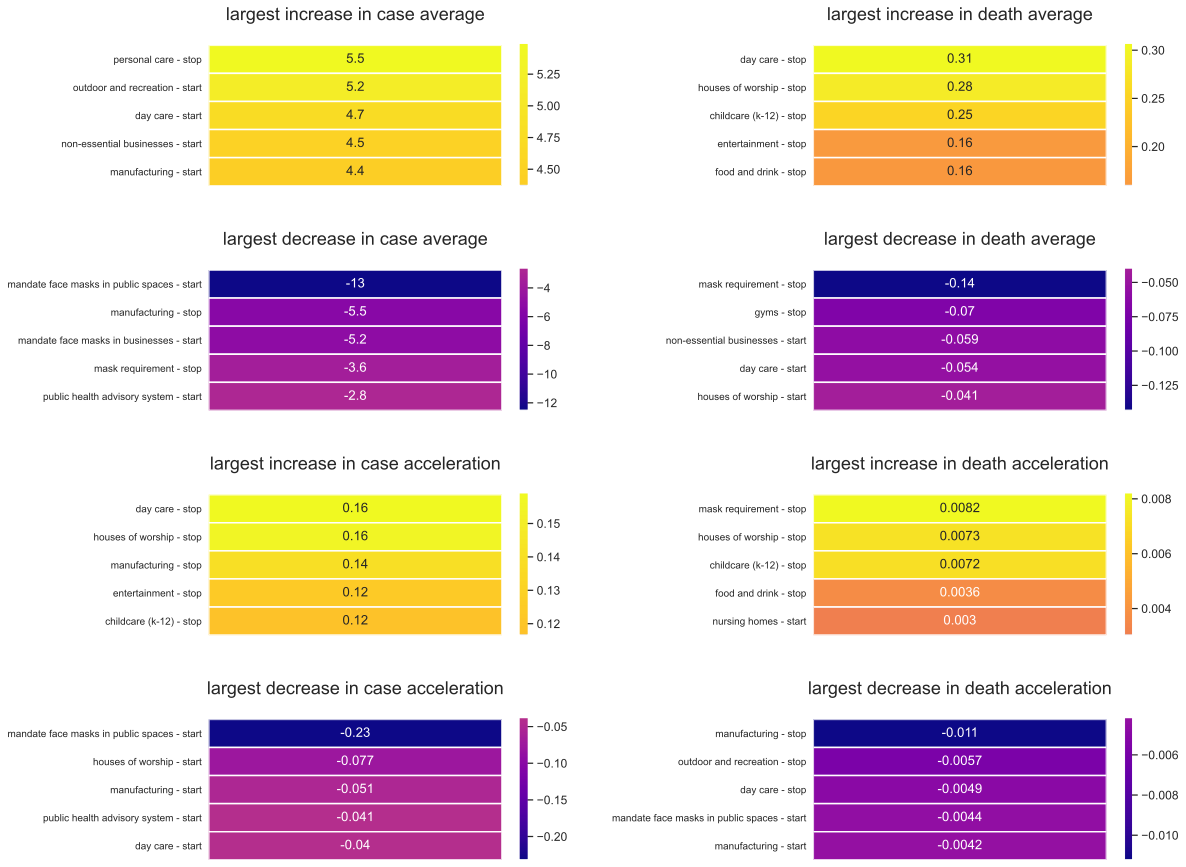

In [49]:
# Filter the most extremem of each relation (largest increase / decrease in number / acceleration of new cases / deaths). 
dfs_case = [delta_stats.sort_values(by="case_avg", ascending=False)[["case_avg"]].head(),
            delta_stats.sort_values(by="case_avg", ascending=True)["case_avg"].head(), 
            delta_stats.sort_values(by="case_accel_avg", ascending=False)["case_accel_avg"].head(),
            delta_stats.sort_values(by="case_accel_avg", ascending=True)["case_accel_avg"].head()
           ]

dfs_death = [delta_stats.sort_values(by="death_avg", ascending=False)["death_avg"].head(),
             delta_stats.sort_values(by="death_avg", ascending=True)["death_avg"].head(), 
             delta_stats.sort_values(by="death_accel_avg", ascending=False)["death_accel_avg"].head(),
             delta_stats.sort_values(by="death_accel_avg", ascending=True)["death_accel_avg"].head()
            ]


# Generate arrays for titles. 
titles_case = [
    "largest increase in case average\n",
    "largest decrease in case average\n",
    "largest increase in case acceleration\n",
    "largest decrease in case acceleration\n", 
]

titles_death = [
    "largest increase in death average\n", 
    "largest decrease in death average\n", 
    "largest increase in death acceleration\n", 
    "largest decrease in death acceleration\n"
]

# Set up figures. 
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[15, 15])
plt.subplots_adjust(hspace=0.6, wspace=0.65, left=0)
sns.set(font_scale=1.1)

# Make the plots. 
for i in range(len(ax[:,0])): 
        
        # Plot heatmap for cases. 
        handles = sns.heatmap(np.asarray(dfs_case[i]).reshape(5,1), 
                              yticklabels=dfs_case[i].index, 
                              xticklabels="",
                              ax=ax[i,0], 
                              cbar=True, 
                              annot=True, 
                              cmap="plasma",
                              center = 0, 
                              linewidths=1.5
                             )
        ax[i,0].set_title(titles_case[i], fontsize=18)
        
        # Plot heatmap for deaths. 
        handles = sns.heatmap(np.asarray(dfs_death[i]).reshape(5,1), 
                              yticklabels=dfs_death[i].index,
                              xticklabels="", 
                              ax=ax[i,1], 
                              cbar=True, 
                              annot=True, 
                              cmap="plasma", 
                              center = 0,
                              linewidths=1.5
                             )
        ax[i,1].set_title(titles_death[i], fontsize=18)

# 3.3 <a id='3.3'>Discussion</a>
[back to top](#top)<br>

< re-write this section later> 

It is vitally important to remember the correlation =/= causation. For example, even though closing houses of worship is correlated with the largest decrease in case acceleration, the does not mean that closing houses of worship CAUSED the largest decrease in case acceleration. There are many, many variables involved. 

# 3.4 <a id='3.4'>linear regression</a> (in development)
[back to top](#top)<br>

< re-write the intro for this section later > 

### OLD &#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;
It should be possible to use a linear regression algorithm to "uncouple" these multiple policies to estimate the contribution that each policy type had to easing or worsening the case / death rates. When implementing this, my first thought is to try a model such as this: 

$$c(d) = \sum_{all policies} P_{i} \omega_{i}f(\delta d)$$

Where 
- $c(d)$ = the case or death rate acceleration on a specified day in any given county $d$
- $P_{i}$ is 1 if the policy was enacted in the county or state $\delta d$ days before the date of interest, 0 if not
- $\omega_{i}$ = the impact weight of an enacted policy
- $f(\delta d)$ = the time weight- a function that accounts for the time delay between policy enactment and change in cases. This should be a minimum 1 day after policy enactment and increases until the "golden zone" where the policy is most effective. 

This would constitute a system of equations for one equation for each row of the covid-19 case / policy dataframe, or about 800,000 equations. Not counting the 'time weight', this would be paired with 57 policy types, wich is easily solvable with linear regression. The time weight may introduce complexities into the model, as the linear regression algorithm would be solving for $\omega_{i}f(\delta d)$, so selecting $f(\delta d)$ to be a continuous function may result in solving for too many unknowns. The time weight could be chosen for specific time windows, for example 1-7 days, 7-14 day, 14-21 days, and 21+ days and may or may not change between policies. 


At the moment, my priority is to build as many projects as I can, as since I've already spent more time messing with this one than I intended, I'll be putting the linear regression implementation on the back burner until March of 2021. During that time I'll be taking a course in applied artificial intelligence, in which I hope to learn the tools necessary to implement this final step. 

For those interested in seeing this kind of linear regresstion in action, I would suggest reading the paper by [Klimek et al.](https://www.nature.com/articles/s41562-020-01009-0?fbclid=IwAR2fnHNxYtB54oHuyQmz8rEpuypgwvbWvSnY8fOQg7Zt_bLA13HsZZvecrY) which used 4 different computational methods to correlate the case case and policy data at the international scale. 

### NEW &#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;&#8595;

# BEGIN DEV SECTION

For the sake of efficiency, let's drop policies that have not been enacted more than 10 times and group similar policies

In [50]:
df2['policy_type'].value_counts()

shelter in place                            847
food and drink                              300
mask requirement                            261
non-essential businesses                    256
outdoor and recreation                      254
entertainment                               198
childcare (k-12)                            192
houses of worship                           116
gyms                                         94
manufacturing                                78
day care                                     73
personal care                                60
state of emergency                           50
modify medicaid requirements                 50
expand medicaid telehealth coverage          49
allow audio only telehealth                  45
mandate face masks in businesses             45
mandate face masks in public spaces          37
order freezing utility shut offs             32
suspend elective dental procedures           32
stop initiation of evictions            

In [51]:
df2['policy_type'].sort_values().unique()

array(['aca special enrollment period', 'agriculture',
       'allow audio only telehealth', 'alternative care facilities ',
       'bars', 'childcare (k-12)', 'colleges & universities',
       'construction', 'day camps/overnight camps', 'day care',
       'education', 'election', 'entertainment', 'executive order',
       'expand medicaid telehealth coverage', 'food and drink',
       'froze mortgage payments', 'gatherings',
       'grace period / security deposit for rent', 'graduation',
       'graduation ceremony guidelines', 'gyms', 'health risk status',
       'higher education', 'houses of worship', 'libraries',
       'mandate face masks in businesses',
       'mandate face masks in public spaces', 'manufacturing',
       'mask requirement', 'medical', 'modify medicaid requirements',
       'museums', 'non-essential businesses', 'nursing home visitations',
       'nursing homes', 'order freezing utility shut offs',
       'outdoor and recreation', 'personal care', 'public gath

In [52]:
policy_dict = {
    'aca special enrollment period' : 'medical', 
    'agriculture' : 'agriculture',
    'allow audio only telehealth' : 'medical', 
    'alternative care facilities' : 'medical', 
    'bars' : 'entertainement', 
    'childcare (k-12)' : 'childcare', 
    'colleges & universities' : 'education',
    'construction' : 'construction', 
    'day camps/overnight camps' : 'camps', 
    'day care' : 'childcare',
    'education' : 'education', 
    'election' : 'election', 
    'entertainment' : 'entertainment', 
    'executive order' : 'executive order',
    'expand medicaid telehealth coverage' : 'medical', 
    'food and drink' : 'entertainment',
    'froze mortgage payments' : 'housing', 
    'gatherings' : 'gatherings', 
    'grace period / security deposit for rent' : 'housing', 
    'graduation' : 'graduation',
    'graduation ceremony guidelines' : 'graduation', 
    'gyms' : 'gyms', 
    'health risk status' : 'medical',
    'higher education' : 'education', 
    'houses of worship' : 'houses of worship', 
    'libraries' : 'education',
    'mandate face masks in businesses' : 'mask mandate',
    'mandate face masks in public spaces' : 'mask mandate', 
    'manufacturing' : 'manufacturing',
    'mask requirement' : 'mask mandate', 
    'medical' : 'medical', 
    'modify medicaid requirements' : 'medical',
    'museums' : 'education', 
    'non-essential businesses' : 'non-essential businesses', 
    'nursing home visitations' : 'nursing homes',
    'nursing homes' : 'nursing homes', 
    'order freezing utility shut offs' : 'housing',
    'outdoor and recreation' : 'outdoor and recreation', 
    'personal care' : 'personal care', 
    'public gatherings' : 'gatherings',
    'public health advisory system' : 'medical', 
    'quarantine' : 'shelter in place',
    'residential overnight camps' : 'camps',
    'resumed elective medical procedures' : 'medical', 
    'shelter in place' : 'shelter in place',
    'state of emergency' : 'state of emergency', 
    'state of emergency/funds' : 'state of emergency',
    'stop enforcement of evictions' : 'housing', 
    'stop initiation of evictions' : 'housing',
    'suspend elective dental procedures' : 'medical', 
    'training jobs' : 'training jobs', 
    'travel' : 'travel',
    'traveler from out of state' : 'travel', 
    'updated guidelines' : 'updated guidelines',
    'wholesale trade' : 'wholesale trade',
}

In [53]:
df_policy = df2

In [54]:
for key in policy_dict.keys():
    df_policy['policy_type'].replace(to_replace=key, value=policy_dict[key], inplace=True)

In [55]:
df_policy['policy_type'].value_counts()

shelter in place                848
entertainment                   498
mask mandate                    343
childcare                       265
non-essential businesses        256
outdoor and recreation          254
medical                         249
houses of worship               116
housing                          97
gyms                             94
manufacturing                    78
personal care                    60
state of emergency               52
nursing homes                    32
education                         8
gatherings                        8
travel                            6
executive order                   6
wholesale trade                   5
construction                      4
camps                             2
graduation                        2
alternative care facilities       2
entertainement                    2
updated guidelines                2
agriculture                       1
election                          1
training jobs               

NOTE: will probably have to throw out policies with less than 10 samples. Leaving it how it is for now

make a new dataframe, df3 with the following attributes: 

rows: same as df

columns: 
- num new cases - starting with only one policy (the policy with the most entries in df2)- include bins for how long it has been since the policy was implemented:
- 0-6 days
- 7-13 days
- 14+ days 

These bins will be optimized later. For now, get the data shaped properly and get the model working

## First attempt: 

This one works, but takes ~ 20-30 minutes to process. Currently trying to get this optimized. 

In [57]:
bins_list = ["0-6 days", "7-13 days", "14+ days"]

def process_data(case_df, policy_df, all_policies=None):
    
    policy_df['full_policy'] = policy_df['policy_type'] + " - " + policy_df['start_stop'] + " - " + policy_df['policy_level']
    
    if all_policies is None: 
        all_policies=policy_df['full_policy'].unique()
   
    def get_date_range(date, start_move=0, stop_move=7): 
        return pd.date_range(start=date+timedelta(days=start_move), 
                             end  =date+timedelta(days=stop_move))

    tuples_info = [("info", "county"), ("info", "state"), ("info", "date"), ("info", "new_cases_1e6")]
    tuples_policies = [ (policy, date_range) for policy in all_policies for date_range in bins_list]

    tuples_index = tuples_info + tuples_policies
    col_index = pd.MultiIndex.from_tuples(tuples_index)


    df3 = pd.DataFrame(columns = col_index, 
                       data = {("info", "county") : case_df['county'], 
                       ("info", "state")          : case_df['state'], 
                       ("info", "date")           : case_df['date'], 
                       ("info", "new_cases_1e6")  : case_df['new_cases_1e6']})
    df3 = df3.fillna(0)
   
    i=0
    # loop through all policies
    for policy in all_policies: 
        print(f"policy {i}/{len(all_policies)}")
        i+=1
        # look for where this policy was implemented at the county level
        policy_info = policy_df[["date", "county", "state"]][df2['full_policy'] == policy]

        if len(policy_info) == 0: 
            continue

        for sub_policy_info in policy_info.values: 
            # we are now looping through every policy implementation of a specific type
            # take the date of each policy, modify df3 accordingly note: this currently only works for county policies
            if sub_policy_info[1] != 'statewide': 
                df3.loc[(
                    (df3['info', 'date'].isin(get_date_range(sub_policy_info[0], 0, 6))) &\
                    (df3['info', 'county'] == sub_policy_info[1]) &\
                    (df3['info', 'state'] == sub_policy_info[2])), (policy, "0-6 days")] = 1
                df3.loc[(
                    (df3['info', 'date'].isin(get_date_range(sub_policy_info[0], 7, 13))) &\
                    (df3['info', 'county'] == sub_policy_info[1]) &\
                    (df3['info', 'state'] == sub_policy_info[2])), (policy, "7-13 days")] = 1
                df3.loc[(
                    (df3['info', 'date'].isin(get_date_range(sub_policy_info[0], 14, 9999))) &\
                    (df3['info', 'county'] == sub_policy_info[1]) &\
                    (df3['info', 'state'] == sub_policy_info[2])), (policy, "14+ days")] = 1
            else: 

                df3.loc[(
                    (df3['info', 'date'].isin(get_date_range(sub_policy_info[0], 0, 6))) &\
                    (df3['info', 'state'] == sub_policy_info[2])), (policy, "0-6 days")] = 1
                df3.loc[(
                    (df3['info', 'date'].isin(get_date_range(sub_policy_info[0], 7, 13))) &\
                    (df3['info', 'state'] == sub_policy_info[2])), (policy, "7-13 days")] = 1
                df3.loc[(
                    (df3['info', 'date'].isin(get_date_range(sub_policy_info[0], 14, 9999))) &\
                    (df3['info', 'state'] == sub_policy_info[2])), (policy, "14+ days")] = 1
    clear_output()
    return df3


#time_now = time.time()
#df3 = process_data(df, df2)
#time_end = time.time()
#print(f"data shaped; time_elapsed = {time_end - time_now} seconds")

## Second attempt: 

Optimize the process data algorithm so it doesn't take 30 minutes to run<br>
original time: 0.7293415069580078 seconds (for mecklenburg county, NC)<br>
after several runs: 0.13988852500915527 (with df3 statements commented out)<br>
with new algorithm: 0.15003466606140137 seconds<br>
this algorithm for total dataset: 1273.7204766273499 seconds


In [58]:
bins_list = ["0-6", "7-13", "14-999"]

def process_data(case_df, policy_df, all_policies=None, bins_list=bins_list):
    
    policy_df.loc[:, 'full_policy'] = policy_df['policy_type'] + " - " + policy_df['start_stop'] + " - " + policy_df['policy_level']
    if all_policies is None: 
        all_policies=policy_df['full_policy'].unique()
   
    def get_date_range(date, start_move=0, stop_move=7): 
        return pd.date_range(start=date+timedelta(days=start_move), 
                             end  =date+timedelta(days=stop_move))

    tuples_info = [("info", "county"), ("info", "state"), ("info", "date"), ("info", "new_cases_1e6")]
    tuples_policies = [ (policy, date_range) for policy in all_policies for date_range in bins_list]
    tuples_index = tuples_info + tuples_policies
    col_index = pd.MultiIndex.from_tuples(tuples_index)


    df3 = pd.DataFrame(columns = col_index, 
                       data = {("info", "county") : case_df['county'], 
                       ("info", "state")          : case_df['state'], 
                       ("info", "date")           : case_df['date'], 
                       ("info", "new_cases_1e6")  : case_df['new_cases_1e6']})
    df3 = df3.fillna(0)
   
    i=0
    
    
    # loop through all policies
    for policy in all_policies: 
        print(f"policy {i}/{len(all_policies)}")
        i+=1
        
        # look for where this policy was implemented at the county level
        policy_info = policy_df[["date", "county", "state"]][policy_df['full_policy'] == policy]
        if len(policy_info) == 0: 
            continue

        for sub_policy_info in policy_info.values: 
            # we are now looping through every policy implementation of a specific type
            # take the date of each policy, modify df3 accordingly
            
            #print(sub_policy_info)
            if sub_policy_info[1] != 'statewide':
                for date_bin in bins_list:
                    start, stop = date_bin.split("-")
                    date_range = get_date_range(sub_policy_info[0], int(start), int(stop))
                    df3.loc[(
                            (df3['info', 'date'].isin(date_range)) &\
                            (df3['info', 'county'] == sub_policy_info[1]) &\
                            (df3['info', 'state'] == sub_policy_info[2])), (policy, date_bin)] = 1
            else: 
                for date_bin in bins_list:
                    start, stop = date_bin.split("-")
                    date_range = get_date_range(sub_policy_info[0], int(start), int(stop))
                    df3.loc[(
                            (df3['info', 'date'].isin(date_range)) &\
                            (df3['info', 'state'] == sub_policy_info[2])), (policy, date_bin)] = 1

    return df3


time_now = time.time()
df3 = process_data(case_df = df[(df['county']=='mecklenburg') & (df['state']=='North Carolina')], 
                   policy_df = df_policy[(df_policy['county']=='mecklenburg') & (df_policy['state']=='North Carolina')]
                  )
time_end = time.time()
print(f"data shaped; total time_elapsed = {time_end - time_now} seconds")

policy 0/2
policy 1/2
data shaped; total time_elapsed = 1.2198994159698486 seconds


C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


This didn't really change anything ^^^^


# Third attempt 

Goal: get of as many for loops as possible and replace with vectorized operations

idea: loop through the bins first and do a full vectorized operation 3 times? 

In [59]:

def process_data(case_df, policy_df, bins_list=["0-6", "7-13", "14-999"]):
    def get_date_range(date, start_move=0, stop_move=7): 
            return pd.date_range(start=date+timedelta(days=start_move), 
                                 end  =date+timedelta(days=stop_move))

    policy_df.loc[:, 'full_policy'] = policy_df['policy_type'] + " - " + policy_df['start_stop'] + " - " + policy_df['policy_level']

    # constructing multiindex for df3
    tuples_info = [("info", "state"), ("info", "county"), ("info", "date"), ("info", "new_cases_1e6")]
    tuples_policies = [ (policy, date_range) for policy in all_policies for date_range in bins_list]
    tuples_index = tuples_info + tuples_policies
    col_index = pd.MultiIndex.from_tuples(tuples_index, #names=["level_1", "level_2"]
                                         )

    # construct df3
    df3 = pd.DataFrame(columns = col_index, 
                       data = {
                        ("info", "state")          : case_df['state'],
                        ("info", "county")         : case_df['county'], 
                        ("info", "date")           : case_df['date'], 
                        ("info", "new_cases_1e6")  : case_df['new_cases_1e6']})

    df3.fillna(0, inplace=True)

    time_start = time.time()

    
    for elem in policy_df.itertuples():

        state = elem[1]
        county = elem[2]
        level = elem[4]
        date = elem[5]
        policy = elem[10]

        for date_bin in bins_list:
            start, stop = date_bin.split("-")
            date_range = get_date_range(elem[5], int(start), int(stop))
            df3.loc[(
                    (df3['info', 'date'].isin(date_range)) &\
                    ((df3['info', 'county'] == elem[2]) | (elem[4] == 'statewide')) &\
                    (df3['info', 'state'] == elem[1])), (elem[10], date_bin)] = 1
    return df3

time_start = time.time()

states = df['state'].unique()

df3 = pd.DataFrame()

for state in states:
    state_start = time.time()
    df3 = df3.append(process_data(case_df = df[(df['state']==state)], 
                      policy_df = df_policy[(df_policy['state']==state)].copy()), ignore_index=True)
    state_stop = time.time()
    print(f"{state}: {state_stop - state_start}")
time_end = time.time()
print(f"data shaped; total time_elapsed = {time_end - time_start} seconds")

#df3[(df3["info", "date"]>= pd.to_datetime('2020-04-15 00:00:00')) & (df3['info', 'county']=='mecklenburg')].head(30)

NameError: name 'all_policies' is not defined

Iterating through states seems to be the way to go. 

Implement this in the function: 

In [60]:
df_policy

,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source
0,Mississippi,hinds,28049,county,2020-07-13,entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...
1,Arizona,statewide,4,state,2020-05-16,houses of worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...
2,Oregon,statewide,41,state,2020-05-15,non-essential businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...
5,Connecticut,statewide,9,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database
6,Michigan,statewide,26,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database
...,...,...,...,...,...,...,...,...,...
3802,Texas,castro,48069,county,2020-04-30,shelter in place,stop,Castro County Policy End,wikidata
3803,Ohio,statewide,39,state,2020-05-04,non-essential businesses,stop,Other measures and details for this policy inc...,BU COVID-19 State Policy Database
3805,Mississippi,sunflower,28133,county,2020-07-20,non-essential businesses,stop,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...
3806,Texas,stonewall,48433,county,2020-04-18,shelter in place,stop,Stonewall County Policy End,wikidata


In [72]:
def process_data(case_df, policy_df, output, bins_list=["0-6", "7-13", "14-999"]):
    def get_date_range(date, start_move=0, stop_move=7): 
            return pd.date_range(start=date+timedelta(days=start_move), 
                                 end  =date+timedelta(days=stop_move))

    policy_df.loc[:, 'full_policy'] = policy_df['policy_type'] + " - " + policy_df['start_stop'] + " - " + policy_df['policy_level']
    all_policies = policy_df['full_policy'].unique()
    
    # constructing multiindex for df3
    tuples_info = [("info", "state"), ("info", "county"), ("info", "date"), ("info", "new_cases_1e6")]
    tuples_policies = [ (policy, date_range) for policy in all_policies for date_range in bins_list]
    tuples_index = tuples_info + tuples_policies
    col_index = pd.MultiIndex.from_tuples(tuples_index)

    # construct df3
    df3 = pd.DataFrame()
    
    for state in case_df['state'].unique():
        if output: 
            state_time_start = time.time()
        
        
        frame = pd.DataFrame(columns = pd.MultiIndex.from_tuples(tuples_info + tuples_policies), data = {
            ("info", "state")         : state, 
            ("info", "county")        : case_df['county'][case_df['state']==state], 
            ("info", "date")          : case_df['date'][case_df['state']==state], 
            ("info", "new_cases_1e6") : case_df['new_cases_1e6'][case_df['state']==state]
        })
        if output: 
            print(f"len frame: {len(frame)}")
        for (date, county, policy, level) in zip(filtered_policy['date'], 
                                                 filtered_policy['county'],
                                                 filtered_policy['full_policy'], 
                                                 filtered_policy['policy_level']):

            for date_bin in bins_list: 
                start, stop = date_bin.split("-")
                date_range = get_date_range(date, int(start), int(stop))
                frame.loc[(
                    (frame['info', 'date'].isin(date_range)) &\
                    ((frame['info', 'county'] == county) | (level == 'statewide')) &\
                    (frame['info', 'state'] == state)), (policy, date_bin)] = 1

        f
        df3 = df3.append(frame, ignore_index=True)[frame.columns.tolist()]
        
        if output: 
            state_time_end = time.time()
            print(f"{state}: {state_time_end - state_time_start} seconds")
    df3.fillna(0, inplace=True)
    return df3


time_start = time.time()
df3 = process_data(case_df = df, policy_df = df_policy.copy(), output=True);
time_end = time.time()
print(f"data shaped, time elapsed: {time_end - time_start}")

Alabama: 1.0199689865112305 seconds
Alaska: 1.1197974681854248 seconds
Arizona: 0.9340720176696777 seconds
Arkansas: 1.4451932907104492 seconds
California: 2.7848093509674072 seconds
Colorado: 3.2149980068206787 seconds
Connecticut: 1.6602697372436523 seconds
Delaware: 1.5502724647521973 seconds
Florida: 2.819873809814453 seconds
Georgia: 4.529532432556152 seconds
Hawaii: 2.3851070404052734 seconds
Idaho: 3.9952423572540283 seconds
Illinois: 4.11963963508606 seconds
Indiana: 4.1199586391448975 seconds
Iowa: 4.615107774734497 seconds
Kansas: 5.485090494155884 seconds
Kentucky: 5.634705305099487 seconds
Louisiana: 5.265166282653809 seconds
Maine: 5.043256521224976 seconds
Maryland: 4.7404468059539795 seconds
Massachusetts: 4.839553117752075 seconds
Michigan: 6.360287189483643 seconds
Minnesota: 5.773935317993164 seconds
Mississippi: 9.741691827774048 seconds
Missouri: 7.6625847816467285 seconds
Montana: 6.152832984924316 seconds
Nebraska: 9.477177143096924 seconds
Nevada: 6.5360550880432

In [69]:
df3

info                                    \
         state   county       date new_cases_1e6   
0      Alabama  autauga 2020-01-22          0.00   
1      Alabama  autauga 2020-01-23          0.00   
2      Alabama  autauga 2020-01-24          0.00   
3      Alabama  autauga 2020-01-25          0.00   
4      Alabama  autauga 2020-01-26          0.00   
...        ...      ...        ...           ...   
25053  Alabama  winston 2021-01-25         46.07   
25054  Alabama  winston 2021-01-26         20.94   
25055  Alabama  winston 2021-01-27         50.26   
25056  Alabama  winston 2021-01-28         37.70   
25057  Alabama  winston 2021-01-29         16.75   

      entertainment - start - county              \
                                 0-6 7-13 14-999   
0                                NaN  NaN    NaN   
1                                NaN  NaN    NaN   
2                                NaN  NaN    NaN   
3                                NaN  NaN    NaN   
4                                NaN  NaN    NaN   
...                              ...  ...    ...   
25053                            NaN  NaN    NaN   
25054                            NaN  NaN    NaN   
25055                            NaN  NaN    NaN   
25056                            NaN  NaN    NaN   
25057                            NaN  NaN    NaN   

      houses of worship - start - state              ...  \
                                    0-6 7-13 14-999  ...   
0                                   NaN  NaN    NaN  ...   
1                                   NaN  NaN    NaN  ...   
2                                   NaN  NaN    NaN  ...   
3                                   NaN  NaN    NaN  ...   
4                                   NaN  NaN    NaN  ...   
...                                 ...  ...    ...  ...   
25053                               NaN  NaN    NaN  ...   
25054                               NaN  NaN    NaN  ...   
25055                               NaN  NaN    NaN  ...   
25056                               NaN  NaN    NaN  ...   
25057                               NaN  NaN    NaN  ...   

      state of emergency - stop - state  \
                                 14-999   
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   
...                                 ...   
25053                               NaN   
25054                               NaN   
25055                               NaN   
25056                               NaN   
25057                               NaN   

      alternative care facilities  - stop - state              \
                                              0-6 7-13 14-999   
0                                             NaN  NaN    NaN   
1                                             NaN  NaN    NaN   
2                                             NaN  NaN    NaN   
3                                             NaN  NaN    NaN   
4                                             NaN  NaN    NaN   
...                                           ...  ...    ...   
25053                                         NaN  NaN    NaN   
25054                                         NaN  NaN    NaN   
25055                                         NaN  NaN    NaN   
25056                                         NaN  NaN    NaN   
25057                                         NaN  NaN    NaN   

      alternative care facilities  - start - state              \
                                               0-6 7-13 14-999   
0                                              NaN  NaN    NaN   
1                                              NaN  NaN    NaN   
2                                              NaN  NaN    NaN   
3                                              NaN  NaN    NaN   
4                                              NaN  NaN    NaN   
...    

# Attempt 4 - further optimization

In [106]:
def process_data(case_df, policy_df, output, bins_list=["0-6", "7-13", "14-999"]):
    
    
    def get_date_range(date, start_move=0, stop_move=7): 
            return pd.date_range(start=date+timedelta(days=start_move), 
                                 end  =date+timedelta(days=stop_move))

    policy_df.loc[:, 'full_policy'] = policy_df['policy_type'] + " - " + policy_df['start_stop'] + " - " + policy_df['policy_level']
    all_policies = policy_df['full_policy'].unique()
    
    # constructing multiindex for df3
    tuples_info = [("info", "state"), ("info", "county"), ("info", "date"), ("info", "new_cases_1e6")]
    tuples_policies = [ (policy, date_range) for policy in all_policies for date_range in bins_list]
    tuples_index = tuples_info + tuples_policies
    col_index = pd.MultiIndex.from_tuples(tuples_index)

    # construct df3
    df3 = pd.DataFrame()
    
    all_states = case_df['state'].unique()
    
    frames = [(pd.DataFrame(columns = pd.MultiIndex.from_tuples(tuples_info + tuples_policies), data = {
            ("info", "state")         : state, 
            ("info", "county")        : case_df['county'][case_df['state']==state], 
            ("info", "date")          : case_df['date'][case_df['state']==state], 
            ("info", "new_cases_1e6") : case_df['new_cases_1e6'][case_df['state']==state]
        }), state) for state in all_states]

    for (i, state) in enumerate(all_states):
        if output: 
            state_time_start = time.time()
        filtered_policy = policy_df[policy_df['state']==state]
        for (date, county, policy, level) in zip(filtered_policy['date'], 
                                                 filtered_policy['county'],
                                                 filtered_policy['full_policy'], 
                                                 filtered_policy['policy_level']):
            for date_bin in bins_list: 
                start, stop = date_bin.split("-")
                date_range = get_date_range(date, int(start), int(stop))
                frames[i][0].loc[(
                    (frames[i][0]['info', 'date'].isin(date_range)) &\
                    ((frames[i][0]['info', 'county'] == county) | (level == 'statewide')) &\
                    (frames[i][0]['info', 'state'] == state)), (policy, date_bin)] = 1
        if output: 
            state_time_end = time.time()
            print(f"{state}: {state_time_end - state_time_start} seconds")
    df3 = pd.concat([frames[i][0] for i in range(len(frames))])
    df3.fillna(0, inplace=True)
    return df3


time_start = time.time()
df3 = process_data(case_df = df, policy_df = df_policy.copy(), output=True);
time_end = time.time()
print(f"data shaped, time elapsed: {time_end - time_start}")

Alabama: 2.8640966415405273 seconds
Alaska: 0.6558942794799805 seconds
Arizona: 0.3802511692047119 seconds
Arkansas: 0.3898928165435791 seconds
California: 1.860421895980835 seconds
Colorado: 1.2193048000335693 seconds
Connecticut: 0.21024870872497559 seconds
Delaware: 0.2097339630126953 seconds
Florida: 32.27740240097046 seconds
Georgia: 1.7328734397888184 seconds
Hawaii: 0.30980563163757324 seconds
Idaho: 1.6902201175689697 seconds
Illinois: 1.1747944355010986 seconds
Indiana: 0.635310173034668 seconds
Iowa: 0.8694453239440918 seconds
Kansas: 1.2064754962921143 seconds
Kentucky: 0.7544956207275391 seconds
Louisiana: 0.4643573760986328 seconds
Maine: 0.5748395919799805 seconds
Maryland: 0.21007466316223145 seconds
Massachusetts: 0.24069833755493164 seconds
Michigan: 1.4572336673736572 seconds
Minnesota: 0.5721433162689209 seconds
Mississippi: 4.9148030281066895 seconds
Missouri: 2.3950183391571045 seconds
Montana: 0.30997705459594727 seconds
Nebraska: 3.9206159114837646 seconds
Nevada

# Attempt 5: put everything in a comprehension

In [114]:
def process_data(case_df, policy_df, output, bins_list=["0-6", "7-13", "14-999"]):
    
    
    def get_date_range(date, start_move=0, stop_move=7): 
            return pd.date_range(start=date+timedelta(days=start_move), 
                                 end  =date+timedelta(days=stop_move))

    policy_df.loc[:, 'full_policy'] = policy_df['policy_type'] + " - " + policy_df['start_stop'] + " - " + policy_df['policy_level']
    all_policies = policy_df['full_policy'].unique()
    
    # constructing multiindex for df3
    tuples_info = [("info", "state"), ("info", "county"), ("info", "date"), ("info", "new_cases_1e6")]
    tuples_policies = [ (policy, date_range) for policy in all_policies for date_range in bins_list]
    tuples_index = tuples_info + tuples_policies
    col_index = pd.MultiIndex.from_tuples(tuples_index)
        
        
    all_states = case_df['state'].unique()
    frames = [pd.DataFrame() for state in all_states]
    
    for (i, state) in enumerate(all_states):
        if output: 
            state_time_start = time.time()
            
        frames[i] = pd.DataFrame(columns = pd.MultiIndex.from_tuples(tuples_info + tuples_policies), data = {
            ("info", "state")         : state, 
            ("info", "county")        : case_df['county'][case_df['state']==state], 
            ("info", "date")          : case_df['date'][case_df['state']==state], 
            ("info", "new_cases_1e6") : case_df['new_cases_1e6'][case_df['state']==state]
        })
        
        filtered_policy = policy_df[policy_df['state']==state]
        for (date, county, policy, level) in zip(filtered_policy['date'], 
                                                 filtered_policy['county'],
                                                 filtered_policy['full_policy'], 
                                                 filtered_policy['policy_level']):
            for date_bin in bins_list: 
                start, stop = date_bin.split("-")
                date_range = get_date_range(date, int(start), int(stop))
                frames[i].loc[(
                    (frames[i]['info', 'date'].isin(date_range)) &\
                    ((frames[i]['info', 'county'] == county) | (level == 'statewide')) &\
                    (frames[i]['info', 'state'] == state)), (policy, date_bin)] = 1
        if output: 
            state_time_end = time.time()
            print(f"{state}: {state_time_end - state_time_start} seconds")
    df3 = pd.concat([frames[i] for i in range(len(frames))])
    df3.fillna(0, inplace=True)
    return df3


time_start = time.time()
df3 = process_data(case_df = df, policy_df = df_policy.copy(), output=True);
time_end = time.time()
print(f"data shaped, time elapsed: {time_end - time_start}")

Alabama: 0.8240334987640381 seconds
Alaska: 0.8558249473571777 seconds
Arizona: 0.6500141620635986 seconds
Arkansas: 0.8054251670837402 seconds
California: 1.8954577445983887 seconds
Colorado: 1.4893064498901367 seconds
Connecticut: 0.419802188873291 seconds
Delaware: 0.34000134468078613 seconds
Florida: 1.2498528957366943 seconds
Georgia: 2.441272497177124 seconds
Hawaii: 0.4287149906158447 seconds
Idaho: 1.9003612995147705 seconds
Illinois: 1.9196765422821045 seconds
Indiana: 1.2497785091400146 seconds
Iowa: 1.4907031059265137 seconds
Kansas: 1.8598806858062744 seconds
Kentucky: 1.3794338703155518 seconds
Louisiana: 0.9049627780914307 seconds
Maine: 0.94757080078125 seconds
Maryland: 0.5400032997131348 seconds
Massachusetts: 0.5401630401611328 seconds
Michigan: 2.269427537918091 seconds
Minnesota: 1.1004393100738525 seconds
Mississippi: 5.479841709136963 seconds
Missouri: 3.119992733001709 seconds
Montana: 0.6902282238006592 seconds
Nebraska: 4.989734172821045 seconds
Nevada: 0.41998

# v6: convert bins input to integers for easier manipulation

In [123]:
bins_list=[(0, 6), (7, 13), (14, 999)]

In [138]:
for date_range in bins_list: 
    print(str(date_range[0]) + "-" + str(date_range[1]))

0-6
7-13
14-999


In [142]:
def process_data(case_df, policy_df, output, bins_list=[(0, 6), (7, 13), (14, 999)]):
    
    def get_date_range(date, start_move=0, stop_move=7): 
            return pd.date_range(start=date+timedelta(days=start_move), 
                                 end  =date+timedelta(days=stop_move))

    policy_df.loc[:, 'full_policy'] = policy_df['policy_type'] + " - " + policy_df['start_stop'] + " - " + policy_df['policy_level']
    all_policies = policy_df['full_policy'].unique()
    
    # constructing multiindex for df3
    tuples_info = [("info", "state"), ("info", "county"), ("info", "date"), ("info", "new_cases_1e6")]

    tuples_policies = [ (policy, (str(date_range[0]) + "-" + str(date_range[1]))) 
                       for policy in all_policies for date_range in bins_list]
    tuples_index = tuples_info + tuples_policies
    col_index = pd.MultiIndex.from_tuples(tuples_index)
        
        
    all_states = case_df['state'].unique()
    frames = [pd.DataFrame() for state in all_states]
    
    for (i, state) in enumerate(all_states):
        if output: 
            state_time_start = time.time()
            
        frames[i] = pd.DataFrame(columns = pd.MultiIndex.from_tuples(tuples_info + tuples_policies), data = {
            ("info", "state")         : state, 
            ("info", "county")        : case_df['county'][case_df['state']==state], 
            ("info", "date")          : case_df['date'][case_df['state']==state], 
            ("info", "new_cases_1e6") : case_df['new_cases_1e6'][case_df['state']==state]
        })
        
        filtered_policy = policy_df[policy_df['state']==state]
        for (date, county, policy, level) in zip(filtered_policy['date'], 
                                                 filtered_policy['county'],
                                                 filtered_policy['full_policy'], 
                                                 filtered_policy['policy_level']):
            for date_bin in bins_list: 
                date_range = get_date_range(date, date_bin[0], date_bin[1])
                label = (str(date_range[0]) + "-" + str(date_range[1]))
                frames[i].loc[(
                    (frames[i]['info', 'date'].isin(date_range)) &\
                    ((frames[i]['info', 'county'] == county) | (level == 'statewide')) &\
                    (frames[i]['info', 'state'] == state)), (policy, label)] = 1
            #return frames[i]
        if output: 
            state_time_end = time.time()
            print(f"{state}: {state_time_end - state_time_start} seconds")
    df3 = pd.concat([frames[i] for i in range(len(frames))])
    df3.fillna(0, inplace=True)
    return df3


time_start = time.time()
df3 = process_data(case_df = df, policy_df = df_policy.copy(), output=True);
time_end = time.time()
print(f"data shaped, time elapsed: {time_end - time_start}")

Alabama: 2.4986374378204346 seconds
Alaska: 1.7931294441223145 seconds
Arizona: 0.7015862464904785 seconds
Arkansas: 1.1337852478027344 seconds
California: 4.464128017425537 seconds
Colorado: 3.76454496383667 seconds
Connecticut: 0.5094022750854492 seconds
Delaware: 0.3715536594390869 seconds
Florida: 2.8912580013275146 seconds
Georgia: 6.574850559234619 seconds
Hawaii: 0.4952385425567627 seconds
Idaho: 2.5799083709716797 seconds
Illinois: 3.1351966857910156 seconds
Indiana: 2.187501907348633 seconds
Iowa: 2.1196200847625732 seconds
Kansas: 2.9879910945892334 seconds
Kentucky: 2.2308104038238525 seconds
Louisiana: 1.438758373260498 seconds
Maine: 0.9248628616333008 seconds
Maryland: 0.6119604110717773 seconds
Massachusetts: 0.5798802375793457 seconds
Michigan: 2.5308916568756104 seconds
Minnesota: 1.567434310913086 seconds
Mississippi: 6.434509038925171 seconds
Missouri: 6.170296907424927 seconds
Montana: 0.9236955642700195 seconds
Nebraska: 6.208605766296387 seconds
Nevada: 0.46072220

MemoryError: Unable to allocate 8.96 MiB for an array with shape (1, 1174734) and data type float64

In [141]:
df3

info                                    \
         state   county       date new_cases_1e6   
29920  Alabama  autauga 2020-01-22          0.00   
29921  Alabama  autauga 2020-01-23          0.00   
29922  Alabama  autauga 2020-01-24          0.00   
29923  Alabama  autauga 2020-01-25          0.00   
29924  Alabama  autauga 2020-01-26          0.00   
...        ...      ...        ...           ...   
54973  Alabama  winston 2021-01-25         46.07   
54974  Alabama  winston 2021-01-26         20.94   
54975  Alabama  winston 2021-01-27         50.26   
54976  Alabama  winston 2021-01-28         37.70   
54977  Alabama  winston 2021-01-29         16.75   

      entertainment - start - county              \
                                 0-6 7-13 14-999   
29920                            NaN  NaN    NaN   
29921                            NaN  NaN    NaN   
29922                            NaN  NaN    NaN   
29923                            NaN  NaN    NaN   
29924                            NaN  NaN    NaN   
...                              ...  ...    ...   
54973                            NaN  NaN    NaN   
54974                            NaN  NaN    NaN   
54975                            NaN  NaN    NaN   
54976                            NaN  NaN    NaN   
54977                            NaN  NaN    NaN   

      houses of worship - start - state              ...  \
                                    0-6 7-13 14-999  ...   
29920                               NaN  NaN    NaN  ...   
29921                               NaN  NaN    NaN  ...   
29922                               NaN  NaN    NaN  ...   
29923                               NaN  NaN    NaN  ...   
29924                               NaN  NaN    NaN  ...   
...                                 ...  ...    ...  ...   
54973                               NaN  NaN    NaN  ...   
54974                               NaN  NaN    NaN  ...   
54975                               NaN  NaN    NaN  ...   
54976                               NaN  NaN    NaN  ...   
54977                               NaN  NaN    NaN  ...   

      alternative care facilities  - stop - state  \
                                           14-999   
29920                                         NaN   
29921                                         NaN   
29922                                         NaN   
29923                                         NaN   
29924                                         NaN   
...                                           ...   
54973                                         NaN   
54974                                         NaN   
54975                                         NaN   
54976                                         NaN   
54977                                         NaN   

      alternative care facilities  - start - state              \
                                               0-6 7-13 14-999   
29920                                          NaN  NaN    NaN   
29921                                          NaN  NaN    NaN   
29922                                          NaN  NaN    NaN   
29923                                          NaN  NaN    NaN   
29924                                          NaN  NaN    NaN   
...                                            ...  ...    ...   
54973                                          NaN  NaN    NaN   
54974                                          NaN  NaN    NaN   
54975                                          NaN  NaN    NaN   
54976                                          NaN  NaN    NaN   
54977                                          NaN  NaN    NaN   

      agriculture - start - county              \
                               0-6 7-13 14-999   
29920                          NaN  NaN    NaN   
29921                          NaN  NaN    NaN   
29922                          NaN  NaN    NaN   
29923                          NaN  NaN    NaN   
29924                     


# END DEV SECTION

filter df3 to a known policy implemenation to check

In [115]:
df3.columns

MultiIndex([(                                        'info',         'state'),
            (                                        'info',        'county'),
            (                                        'info',          'date'),
            (                                        'info', 'new_cases_1e6'),
            (              'entertainment - start - county',           '0-6'),
            (              'entertainment - start - county',          '7-13'),
            (              'entertainment - start - county',        '14-999'),
            (           'houses of worship - start - state',           '0-6'),
            (           'houses of worship - start - state',          '7-13'),
            (           'houses of worship - start - state',        '14-999'),
            ...
            (           'state of emergency - stop - state',        '14-999'),
            ( 'alternative care facilities  - stop - state',           '0-6'),
            ( 'alternative care faci

In [116]:
df3[df3['info', 'state'] == 'North Carolina']

info                                     \
                 state    county       date new_cases_1e6   
736780  North Carolina  alamance 2020-01-22          0.00   
736781  North Carolina  alamance 2020-01-23          0.00   
736782  North Carolina  alamance 2020-01-24          0.00   
736783  North Carolina  alamance 2020-01-25          0.00   
736784  North Carolina  alamance 2020-01-26          0.00   
...                ...       ...        ...           ...   
774175  North Carolina    yancey 2021-01-25          5.66   
774176  North Carolina    yancey 2021-01-26         16.98   
774177  North Carolina    yancey 2021-01-27         79.24   
774178  North Carolina    yancey 2021-01-28         96.22   
774179  North Carolina    yancey 2021-01-29        169.81   

       entertainment - start - county              \
                                  0-6 7-13 14-999   
736780                              0    0      0   
736781                              0    0      0   
736782                              0    0      0   
736783                              0    0      0   
736784                              0    0      0   
...                               ...  ...    ...   
774175                              0    0      0   
774176                              0    0      0   
774177                              0    0      0   
774178                              0    0      0   
774179                              0    0      0   

       houses of worship - start - state              ...  \
                                     0-6 7-13 14-999  ...   
736780                                 0    0      0  ...   
736781                                 0    0      0  ...   
736782                                 0    0      0  ...   
736783                                 0    0      0  ...   
736784                                 0    0      0  ...   
...                                  ...  ...    ...  ...   
774175                                 0    0      0  ...   
774176                                 0    0      0  ...   
774177                                 0    0      0  ...   
774178                                 0    0      0  ...   
774179                                 0    0      0  ...   

       state of emergency - stop - state  \
                                  14-999   
736780                                 0   
736781                                 0   
736782                                 0   
736783                                 0   
736784                                 0   
...                                  ...   
774175                                 0   
774176                                 0   
774177                                 0   
774178                                 0   
774179                                 0   

       alternative care facilities  - stop - state              \
                                               0-6 7-13 14-999   
736780                                           0    0      0   
736781                                           0    0      0   
736782                                           0    0      0   
736783                                           0    0      0   
736784                                           0    0      0   
...                                            ...  ...    ...   
774175                                           0    0      0   
774176                                           0    0      0   
774177                                           0    0      0   
774178                                           0    0      0   
774179                                           0    0      0   

       alternative care facilities  - start - state              \
                                                0-6 7-13 14-999   
736780                                            0    0      0   
736781                                            0    0      0   
736782                                  

In [117]:
df3.loc[(df3['info', 'date'] >= pd.to_datetime('2020-03-25 00:00:00')) &\
        (df3['info', 'county'] == 'mecklenburg') &\
        (df3['info', 'state'] == 'North Carolina'), 
        [('info', 'date'), 
         ('info', 'county'),
         ('info', 'state'),
         ('shelter in place - start - county', '0-6'), 
         ('shelter in place - start - county', '7-13'), 
         ('shelter in place - start - county', '14-999')]].head(30)

info                               \
             date       county           state   
758909 2020-03-25  mecklenburg  North Carolina   
758910 2020-03-26  mecklenburg  North Carolina   
758911 2020-03-27  mecklenburg  North Carolina   
758912 2020-03-28  mecklenburg  North Carolina   
758913 2020-03-29  mecklenburg  North Carolina   
758914 2020-03-30  mecklenburg  North Carolina   
758915 2020-03-31  mecklenburg  North Carolina   
758916 2020-04-01  mecklenburg  North Carolina   
758917 2020-04-02  mecklenburg  North Carolina   
758918 2020-04-03  mecklenburg  North Carolina   
758919 2020-04-04  mecklenburg  North Carolina   
758920 2020-04-05  mecklenburg  North Carolina   
758921 2020-04-06  mecklenburg  North Carolina   
758922 2020-04-07  mecklenburg  North Carolina   
758923 2020-04-08  mecklenburg  North Carolina   
758924 2020-04-09  mecklenburg  North Carolina   
758925 2020-04-10  mecklenburg  North Carolina   
758926 2020-04-11  mecklenburg  North Carolina   
758927 2020-04-12  mecklenburg  North Carolina   
758928 2020-04-13  mecklenburg  North Carolina   
758929 2020-04-14  mecklenburg  North Carolina   
758930 2020-04-15  mecklenburg  North Carolina   
758931 2020-04-16  mecklenburg  North Carolina   
758932 2020-04-17  mecklenburg  North Carolina   
758933 2020-04-18  mecklenburg  North Carolina   
758934 2020-04-19  mecklenburg  North Carolina   
758935 2020-04-20  mecklenburg  North Carolina   
758936 2020-04-21  mecklenburg  North Carolina   
758937 2020-04-22  mecklenburg  North Carolina   
758938 2020-04-23  mecklenburg  North Carolina   

       shelter in place - start - county              
                                     0-6 7-13 14-999  
758909                                 0    0      0  
758910                                 1    0      0  
758911                                 1    0      0  
758912                                 1    0      0  
758913                                 1    0      0  
758914                                 1    0      0  
758915                                 1    0      0  
758916                                 1    0      0  
758917                                 0    1      0  
758918                                 0    1      0  
758919                                 0    1      0  
758920                                 0    1      0  
758921                                 0    1      0  
758922                                 0    1      0  
758923                                 0    1      0  
758924                                 0    0      1  
758925                                 0    0      1  
758926                                 0    0      1  
758927                                 0    0      1  
758928                                 0    0      1  
758929                                 0    0      1  
758930                                 0    0      1  
758931                                 0    0      1  
758932                                 0    0      1  
758933                                 0    0      1  
758934                                 0    0      1  
758935                                 0    0      1  
758936                                 0    0      1  
758937                                 0    0      1  
758938                                 0    0      1

## Implement linear regression

In [ ]:
X = df3.loc[:, df2['full_policy'].unique()].values
y = df3.loc[:, ('info', 'new_cases_1e6')].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Evaluate model performance

In [ ]:
coefficients = regressor.coef_
print(f"regression coefficients:")
coefficients

**build df of results**

In [ ]:
df3

In [ ]:
results = pd.DataFrame(index=df3.columns[4:], data={"coefficient": coefficients})
results = results.unstack()
results

In [ ]:
# plot the relative magnitudes of the weights for each policy

fig, ax = plt.subplots(nrows=20, ncols=5, figsize=[25, 100])
i = j = 0 # j = column, i = row
x = [elem [1] for elem in results.columns.tolist()]

for index in results.index:
    # set indices
    if j==5: 
        j=0
        i+=1
    g = sns.scatterplot(x=x, 
                    y=results.loc[index].values, 
                    ax=ax[i][j], 
                    s=300, 
                    hue=results.loc[index].values)
    
    g.legend_.remove()
    
    ax[i][j].set_title(index)
    j+=1
fig.suptitle("# new cases associated with covid policies 0-6 days, 7-13 days, and 14+ days after implementation", y=0.89);

**Note**: The weight explosion with policies such as 'Phase 2, 3 - stop - state' can be stopped by using LASSO- which uses least squares + absolute value of the weight as the error function, and possibly with other more sophisticated regression methods

# TODO: make to-do list for next steps to improve model

In [ ]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)

print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), axis=1))

# 4. <a id='4'>Conclusion</a>
[back to top](#top)<br>

To summarize, we cleaned 2 datasets: one on the covid-19 case and death numbers and another on the policy data. We plotted the case data at the country and state level and correlated those with policy implementations. Finally, we more elegantly correlated the policies with case data by aggregating all the policy implementations to get a measure on the change in cases and deaths, as well as how fast those case and death numbers are changing (acceleration). 